In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as scop
import matplotlib.pyplot as plt
import os
import ctypes
import sys
from sklearn.metrics import mean_squared_error as MSE
from scipy.interpolate import interp1d


In [2]:
plt.style.use('../styles/general.mplstyle')

In [3]:
sys.path.append("../src/python_scripts/")
from functions import scale, rescale, calculate_full_trace, OLD_calculate_full_trace, give_me_ina, OLD_give_me_ina,OLD_loss, loss,spec_log_scale,  despec_log_scale


In [4]:
filename_protocol = "../data/protocols/protocol_79.csv"
df_protocol = pd.read_csv(filename_protocol, index_col=0) 


In [5]:
dirname = '../src/model_ctypes/ina/'

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')['value']

In [6]:
S = legend_states.copy()
R = S.copy() * 0
C = legend_constants.copy()
A = legend_algebraic.copy()

output_len = len(df_protocol)

In [7]:
bounds=np.array([[-30.14184674, -26.14184674],
       [-25.71899811, -21.71899811],
       [ 9,  13],
       [  -1. ,   3. ],
       [ 0.,  4.],
       [  0.5 ,   4.5 ],
       [ -4.16282315,  -0.16282315],
       [  5.3588309 ,   9.3588309 ],
       [  1.17805383,   5.17805383],
       [  1.8286414 ,   5.8286414 ],
       [  4.04878828,  10.04878828],
       [-11.08812274,  -7.08812274],
       [  0.11384297,   4.11384297],
       [  1.64805746,   5.64805746],
       [ -5.91202301,  -1.91202301],
       [ 15.03438638,  19.03438638],
       [  9.15625052,  13.15625052],
       [  4.05678401,   9.05678401],
       [ -2.        ,   2.        ],
       [ -11.5129    ,   -7.41858    ],
       [  0.34180581,   50],
       [  20,   90],
       [  1e-3,   20],
       [ 1e-3,   20],
       [ 0.01,   1.77685645],
       [ 0.01,   2],
       [ 0.00001    ,   0.75    ],
       [ -2.        ,   2.        ]])

In [8]:
diff = (df_protocol.v.shift() - df_protocol.v).fillna(0)
mask_capacity = diff.rolling(window=200).sum() !=0
indices_weight_c = mask_capacity.index.to_numpy()[mask_capacity] + 15

mask_INa = diff.rolling(window=600).sum()<-10
indices_weight_INa = mask_INa.index.to_numpy()[mask_INa] + 15

weight = np.zeros_like(df_protocol.v) + 5
weight[indices_weight_c] = 10
weight[indices_weight_INa] = 30

## LSODA

In [9]:
filename = 'ina.so'
filename_so = os.path.join(dirname, filename)
filename_abs = os.path.abspath(filename_so)
filename_abs

'/home/nik/Documents/comparison/INa_full_trace/src/model_ctypes/ina/ina.so'

In [10]:
p0  = C.value.values[:-2].copy()
p = spec_log_scale(p0)
p = np.concatenate((np.log(p0[:-8]), p0[-8:]))

In [22]:
##KWARGS WORKING
t0 = np.arange(0, 1, 5e-5)
v0 = np.full_like(t0, -80.0)
initial_state_len = len(t0)

t = df_protocol['t'].values
v = df_protocol['v'].values

output_len = len(t)
initial_state_S = pd.DataFrame(np.zeros((initial_state_len, len(S))), columns=legend_states.index)
initial_state_A = pd.DataFrame(np.zeros((initial_state_len, len(A))), columns=legend_algebraic.index)

output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

ina = give_me_ina(filename_abs)
kwargs = dict(S = S,
              t0 = t0,
              v0 = v0,
              initial_state_S = initial_state_S,
              initial_state_A = initial_state_A,
              initial_state_len = initial_state_len,
              #function = ina,
              #dt = 1e-8,
              filename_abs = filename_abs, 
              t = df_protocol['t'].values,
              v = df_protocol['v'].values,
              output_S = output_S,
              output_A = output_A,
              bounds = bounds,
              #sample_weight = weight,
              #rescale = True,
              old_log = True
              #log = True,
             )


NameError: name 'json' is not defined

In [12]:
p = np.array([-2.75666759e+01, -2.45169355e+01,  7.50956909e+00,  1.44161398e+00,
        1.79332247e+00,  3.93559661e+00, -2.09187346e+00,  5.89982192e+00,
        2.69935633e+00,  5.52496945e+00,  8.41710247e+00, -1.07446595e+01,
        3.68838534e-01,  1.59149800e-01, -7.33904986e+00,  1.94084108e+01,
        1.29060380e+01,  1.10000000e+01, -8.28336266e-01,  -9.21,2.42791000e+01,
        5.88927366e+01,  7.55695251e+00,  6.47187180e+00,  6.63918488e-03,
        4.02279734e-02,  7.50000000e-01, -1.00000000e+01])

In [13]:
%%time
res_ina = calculate_full_trace(p, kwargs)

CPU times: user 110 ms, sys: 16.4 ms, total: 127 ms
Wall time: 128 ms


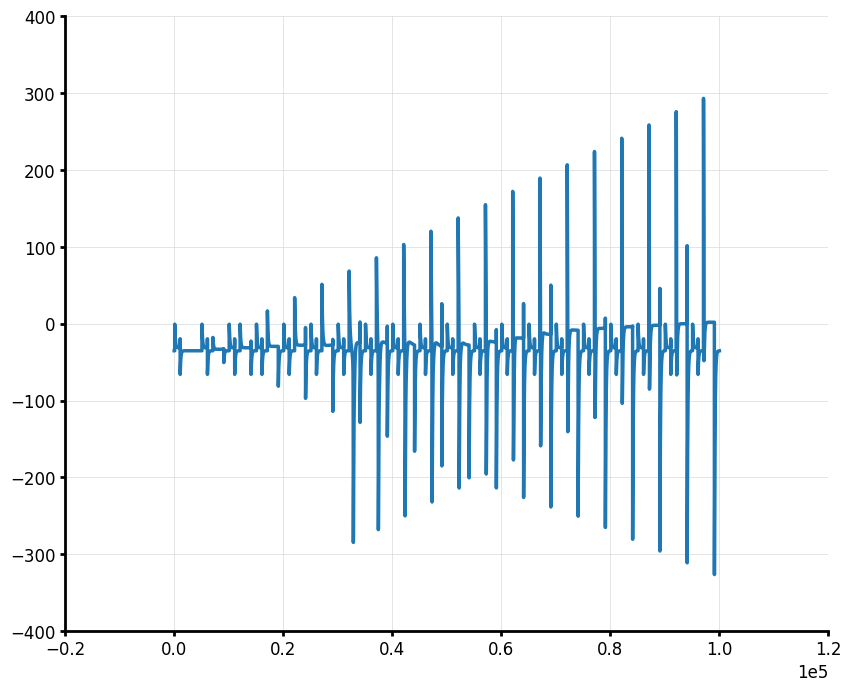

In [14]:
plt.plot(res_ina)

## MCMC

In [14]:
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import pymcmcstat

In [15]:
x_list = np.arange(0, 0.25*20, 5e-5)


In [26]:
kwargs

{'S': name
 v_comp   -80.0
 v_p      -80.0
 v_m      -80.0
 m          0.0
 h          1.0
 j          1.0
 I_out      0.0
 Name: value, dtype: float64,
 't0': array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 9.9985e-01, 9.9990e-01,
        9.9995e-01]),
 'v0': array([-80., -80., -80., ..., -80., -80., -80.]),
 'initial_state_S': name   v_comp  v_p  v_m    m    h    j  I_out
 0         0.0  0.0  0.0  0.0  0.0  0.0    0.0
 1         0.0  0.0  0.0  0.0  0.0  0.0    0.0
 2         0.0  0.0  0.0  0.0  0.0  0.0    0.0
 3         0.0  0.0  0.0  0.0  0.0  0.0    0.0
 4         0.0  0.0  0.0  0.0  0.0  0.0    0.0
 ...       ...  ...  ...  ...  ...  ...    ...
 19995     0.0  0.0  0.0  0.0  0.0  0.0    0.0
 19996     0.0  0.0  0.0  0.0  0.0  0.0    0.0
 19997     0.0  0.0  0.0  0.0  0.0  0.0    0.0
 19998     0.0  0.0  0.0  0.0  0.0  0.0    0.0
 19999     0.0  0.0  0.0  0.0  0.0  0.0    0.0
 
 [20000 rows x 7 columns],
 'initial_state_A': name   tau_m  tau_h  tau_j  m_inf  h_inf  v_cp  I_leak  I

In [23]:
def func(xdata,theta):
    I = calculate_full_trace(theta, kwargs)
    return I

In [24]:
a = p[:1]

In [27]:
func(x_list,p )

array([-35.18444939, -35.18444939, -35.18444938, ..., -35.24990985,
       -35.24929943, -35.24869463])

In [17]:
def loss_mcmc(x, data):
    y = np.concatenate((x.copy(), p[1:]))
    #return 42
    #args = kwargs
    #sample_weight = kwargs.get('sample_weight', None)
    n = len(data.xdata)
    
    I_out = func(data.xdata, y)
    dat = (I_out - np.array(data.ydata[0].T[0]))**2
    return sum(dat)

In [18]:
res_ina_noise = res_ina + np.random.normal(0,5,100000)

In [19]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x = x_list,
                         y = res_ina_noise)#,
                         #user_defined_object= kwargs)
# initialize parameter array
#theta = [0.5, 0.03, 0.1, 10, 0.02, 1.14, 0.77, 1.3, 10]
# add model parameters

mcstat.parameters.add_model_parameter(name=' с_p ', theta0= -26.126285491387264 , minimum= -30.14184674 , maximum= -26.021583203494448 )
#mcstat.parameters.add_model_parameter(name=' c_m ', theta0= -24.422997564541507 , minimum= -25.328436022934504 , maximum= -23.131211445598282 )
#mcstat.parameters.add_model_parameter(name=' a0_m ', theta0= 7.9146016329158435 , minimum= 6.907755278982137 , maximum= 9.210340371976184 )
#mcstat.parameters.add_model_parameter(name=' b0_m ', theta0= 4.267724035266465 , minimum= 2.302585092994046 , maximum= 4.605170185988092 )
#mcstat.parameters.add_model_parameter(name=' delta_m ', theta0= 20.6157 , minimum= 10.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' s_m ', theta0= 9.306083000000001 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' a0_h ', theta0= -0.7756483076716936 , minimum= -2.3025850929940455 , maximum= 0.0 )
#mcstat.parameters.add_model_parameter(name=' b0_h ', theta0= 6.222195640086172 , minimum= 4.605170185988092 , maximum= 6.907755278982137 )
#mcstat.parameters.add_model_parameter(name=' delta_h ', theta0= 15.2348 , minimum= 10.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' s_h ', theta0= 21.96405 , minimum= 10.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' a0_j ', theta0= -0.8039757298133126 , minimum= -2.3025850929940455 , maximum= 0.0 )
#mcstat.parameters.add_model_parameter(name=' b0_j ', theta0= 9.933693232885549 , minimum= 9.210340371976184 , maximum= 11.512925464970229 )
#mcstat.parameters.add_model_parameter(name=' delta_j ', theta0= 4.115303 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' s_j ', theta0= 167.3159 , minimum= 100.0 , maximum= 1000.0 )
#mcstat.parameters.add_model_parameter(name=' tau_j_const ', theta0= -7.156946006769279 , minimum= -9.210340371976182 , maximum= -6.907755278982137 )
#mcstat.parameters.add_model_parameter(name=' R ', theta0= 17.032254912863436 , minimum= 16.11809565095832 , maximum= 18.420680743952367 )
#mcstat.parameters.add_model_parameter(name=' R_f ', theta0= 12.695944463648372 , minimum= 11.512925464970229 , maximum= 13.815510557964274 )
#mcstat.parameters.add_model_parameter(name=' g_max ', theta0= 12.992756616186211 , minimum= 9.210340371976184 , maximum= 13.815510557964274 )
#mcstat.parameters.add_model_parameter(name=' g_leak ', theta0= -0.7313802376061298 , minimum= -2.3025850929940455 , maximum= 2.302585092994046 )
#mcstat.parameters.add_model_parameter(name=' tau_z ', theta0= -9.210000429763085 , minimum= -11.512925464970229 , maximum= -6.907755278982137 )
#mcstat.parameters.add_model_parameter(name=' v_half_m ', theta0= 24.35802 , minimum= 10.0 , maximum= 60.0 )
#mcstat.parameters.add_model_parameter(name=' v_half_h ', theta0= 59.69116999999999 , minimum= 50.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' k_m ', theta0= 5.66677 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' k_h ', theta0= 5.507771 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' x_c_comp ', theta0= -2.309616455184387 , minimum= -4.605170185988091 , maximum= 0.09531017980432493 )
#mcstat.parameters.add_model_parameter(name=' x_r_comp ', theta0= 0.01980262729617973 , minimum= -4.605170185988091 , maximum= 0.09531017980432493 )
#mcstat.parameters.add_model_parameter(name=' alpha ', theta0= -0.2876820724517809 , minimum= -0.35667494393873245 , maximum= -0.2231435513142097 )
#mcstat.parameters.add_model_parameter(name=' v_off ', theta0= 1.55814461804655 , minimum= 0.0 , maximum= 2.302585092994046 )


# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=1.0e3, updatesigma=True)
# Define model object:
mcstat.model_settings.define_model_settings(sos_function=loss_mcmc, S20=np.array([1]),N0=np.array([4]))

In [20]:
s1 = loss_mcmc(p[:1], mcstat.data)
print('s1 = {}'.format(s1))

s1 = 2503843.9576384


In [ ]:
# Run simulation
mcstat.run_simulation()


In [ ]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(16, 10))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
#mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
#f = mcp.plot_pairwise_correlation_panel(chain, names, settings)